### I. Importing libraries

In [1]:
import pandas as pd
from tqdm import tqdm
from PIL import Image
import shutil
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import albumentations as alb
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Add, GlobalMaxPooling2D, Dropout, ReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

2023-10-28 13:30:27.367689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 13:30:27.367752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 13:30:27.368520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 13:30:27.460955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 13:30:28.536275: W tensorflow/compiler/

### II. Defining paths to data files

In [2]:
data_bbox_path = r'/home/legion/Pulpit/All/Github/Model_BBox_CelebA/data/list_bbox_celeba.csv'
img_finall_data_path = r'/home/legion/Pulpit/All/Data/img_celeba_extended'
img_partition_data_path = r'/home/legion/Pulpit/All/Data/img_celeba_partition'
img_raw_data_path = r'/home/legion/Pulpit/All/Data/img_celeba'

### III. Defining functions

In [3]:
######################################
##### Function to get image size #####
######################################

def get_image_dimensions(image_filename):
    image_folder = img_raw_data_path
    image_path = os.path.join(image_folder, image_filename)
    with Image.open(image_path) as img: 
        return img.size

################################
##### Function to load img #####
################################

def load_image(image_path):
    byte_img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(byte_img,)
    return img

###################################
##### Function to build model #####
###################################

def build_model():
    input_layer = Input(shape=(128, 128, 3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    reggress1 = Dense(2048, activation='relu')(f2)
    reggress2 = Dense(4, activation='sigmoid')(reggress1) 

    facetracker = Model(inputs=input_layer, outputs=[class2, reggress2])
    return facetracker

################################################
##### Function to create localization loss #####
################################################

def localization_loss(y_true,y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

### IV. Processing the data

In [4]:
### Uploading bbox data
data_bbox = pd.read_csv(data_bbox_path)
print("1. BBox data uploaded")

### Processing bbox data
data_bbox['TLX'] = data_bbox['x_1']
data_bbox['TLY'] = data_bbox['y_1']
data_bbox['TRX'] = data_bbox['x_1'] + data_bbox['width']
data_bbox['TRY'] = data_bbox['y_1']
data_bbox['BLX'] = data_bbox['x_1']
data_bbox['BLY'] = data_bbox['y_1'] + data_bbox['height']
data_bbox['BRX'] = data_bbox['BLX'] + data_bbox['width']
data_bbox['BRY'] = data_bbox['BLY']
data_bbox = data_bbox.drop(['x_1', 'y_1','width','height'], axis=1)
data_bbox['ISX'], data_bbox['ISY'] = zip(*data_bbox['image_id'].apply(get_image_dimensions))
data_bbox = data_bbox[data_bbox['ISX'] <= 512]
data_bbox = data_bbox[data_bbox['ISY'] <= 512]
print("2. BBox data processed")

### Final preparing images at partition level
if not os.path.exists(img_partition_data_path):
    os.makedirs(img_partition_data_path)
print("3.1. Partition folder created")

if not os.path.exists(os.path.join(img_partition_data_path, 'train')):
    os.makedirs(os.path.join(img_partition_data_path, 'train'))
print("3.2. Partition/train folder created")

if not os.path.exists(os.path.join(img_partition_data_path, 'test')):
    os.makedirs(os.path.join(img_partition_data_path, 'test'))
print("3.3. Partition/test folder created")

if not os.path.exists(os.path.join(img_partition_data_path, 'val')):
    os.makedirs(os.path.join(img_partition_data_path, 'val'))
print("3.4. Partition/val folder created")

train_last_img = int(len(data_bbox)*0.8)
test_last_img = int((len(data_bbox) - train_last_img)/2+train_last_img)

for i in tqdm(range(len(data_bbox))):
    file_name = data_bbox.iloc[i,0]
    if i < train_last_img:
        try: 
            img_raw_path = os.path.join(img_finall_data_path, file_name)
            img_finall_path = os.path.join(img_partition_data_path,'train', file_name)
            shutil.copyfile(img_raw_path, img_finall_path)
        except:
            pass
    elif i < test_last_img and i > train_last_img:
        try:
            img_raw_path = os.path.join(img_finall_data_path, file_name)
            img_finall_path = os.path.join(img_partition_data_path,'test', file_name)
            shutil.copyfile(img_raw_path, img_finall_path)
        except:
            pass
    else:
        try:
            img_raw_path = os.path.join(img_finall_data_path, file_name)
            img_finall_path = os.path.join(img_partition_data_path,'val', file_name)
            shutil.copyfile(img_raw_path, img_finall_path)
        except:
            pass
print("3.5. Imagines copied to partition folders")

### Preparing labels for training test and validation data
train_labels = []
test_labels = []
val_labels = []

for i in tqdm(range(len(data_bbox))):
    img = data_bbox.iloc[i,0]
    
    train_path = os.path.join(img_partition_data_path,'train',img)
    test_path = os.path.join(img_partition_data_path,'test',img)
    val_path = os.path.join(img_partition_data_path,'val',img)

    if os.path.exists(train_path):
        width,height = Image.open(train_path).size
        temp_list = [1,data_bbox.iloc[i,1]/width,data_bbox.iloc[i,2]/height,data_bbox.iloc[i,7]/width,data_bbox.iloc[i,8]/height]
        train_labels.append(temp_list)
    elif os.path.exists(test_path):
        width,height = Image.open(test_path).size
        temp_list = [1,data_bbox.iloc[i,1]/width,data_bbox.iloc[i,2]/height,data_bbox.iloc[i,7]/width,data_bbox.iloc[i,8]/height]
        test_labels.append(temp_list)
    elif os.path.exists(val_path):
        width,height = Image.open(val_path).size
        temp_list = [1,data_bbox.iloc[i,1]/width,data_bbox.iloc[i,2]/height,data_bbox.iloc[i,7]/width,data_bbox.iloc[i,8]/height]
        val_labels.append(temp_list)
print("4.1. Labels list prepared")

tf_train_labels = []
tf_train_bbox = []

for i in tqdm(range(len(train_labels))):
    label = np.array([train_labels[i][0]])
    x1 = train_labels[i][1]
    y1 = train_labels[i][2]
    x2 = train_labels[i][3]
    y2 = train_labels[i][4]
    temp_list = np.array([x1, y1, x2, y2])
    temp_list = tf.convert_to_tensor(temp_list, dtype=tf.float16)
    label = tf.convert_to_tensor(label, dtype=tf.uint8)
    tf_train_labels.append(label)
    tf_train_bbox.append(temp_list)

train_dataset = tf.data.Dataset.from_tensor_slices((tf_train_labels, tf_train_bbox))
print("4.2. Train labels dataset prepared")

tf_test_labels = []
tf_test_bbox = []

for i in tqdm(range(len(test_labels))):
    label = np.array([test_labels[i][0]])
    x1 = test_labels[i][1]
    y1 = test_labels[i][2]
    x2 = test_labels[i][3]
    y2 = test_labels[i][4]
    temp_list = np.array([x1, y1, x2, y2])
    temp_list = tf.convert_to_tensor(temp_list, dtype=tf.float16)
    label = tf.convert_to_tensor(label, dtype=tf.uint8)
    tf_test_labels.append(label)
    tf_test_bbox.append(temp_list)

test_dataset = tf.data.Dataset.from_tensor_slices((tf_test_labels, tf_test_bbox))
print("4.3. Test labels dataset prepared")

tf_val_labels = []
tf_val_bbox = []

for i in tqdm(range(len(val_labels))):
    label = np.array([val_labels[i][0]])
    x1 = val_labels[i][1]
    y1 = val_labels[i][2]
    x2 = val_labels[i][3]
    y2 = val_labels[i][4]
    temp_list = np.array([x1, y1, x2, y2])
    temp_list = tf.convert_to_tensor(temp_list, dtype=tf.float16)
    label = tf.convert_to_tensor(label, dtype=tf.uint8)
    tf_val_labels.append(label)
    tf_val_bbox.append(temp_list)

val_dataset = tf.data.Dataset.from_tensor_slices((tf_val_labels, tf_val_bbox))
print("4.4. Validation labels dataset prepared")

### Preparing images dataset for training test and validation 
train_img = tf.data.Dataset.list_files(os.path.join(img_partition_data_path,'train','*.jpg'),shuffle=False)
train_img = train_img.map(load_image)
train_img = train_img.map(lambda x: tf.image.resize(x, (128,128)))
train_img = train_img.map(lambda x: x/255)
print("5.1. Train images dataset prepared")


test_img = tf.data.Dataset.list_files(os.path.join(img_partition_data_path,'test','*.jpg'),shuffle=False)
test_img = test_img.map(load_image)
test_img = test_img.map(lambda x: tf.image.resize(x, (128,128)))
test_img = test_img.map(lambda x: x/255)
print("5.2. Test images dataset prepared")

val_img = tf.data.Dataset.list_files(os.path.join(img_partition_data_path,'val','*.jpg'),shuffle=False)
val_img = val_img.map(load_image)
val_img = val_img.map(lambda x: tf.image.resize(x, (128,128)))
val_img = val_img.map(lambda x: x/255)
print("5.3. Validation images dataset prepared")

### Preparing final dataset for training test and validation 
train = tf.data.Dataset.zip((train_img, train_dataset))
train = train.take(40000)
train = train.shuffle(44000)
train = train.batch(8)
train = train.prefetch(4)
print("6.1. Train dataset prepared")

test = tf.data.Dataset.zip((test_img, test_dataset))
test = test.take(6000)
test = test.shuffle(6200)
test = test.batch(8)
test = test.prefetch(4)
print("6.2. Test dataset prepared")

val = tf.data.Dataset.zip((val_img, val_dataset))
val = val.take(6000)
val = val.shuffle(6200)
val = val.batch(8)
vaL = val.prefetch(4)
print("6.3. Validation dataset prepared")

1. BBox data uploaded
2. BBox data processed
3.1. Partition folder created
3.2. Partition/train folder created
3.3. Partition/test folder created
3.4. Partition/val folder created


100%|██████████| 119919/119919 [00:42<00:00, 2802.01it/s]


3.5. Imagines copied to partition folders


100%|██████████| 119919/119919 [00:18<00:00, 6496.68it/s]


4.1. Labels list prepared


  0%|          | 0/95706 [00:00<?, ?it/s]2023-10-28 13:32:19.455669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-28 13:32:19.593387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-28 13:32:19.593662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux

4.2. Train labels dataset prepared


100%|██████████| 11963/11963 [00:02<00:00, 5016.06it/s]


4.3. Test labels dataset prepared


100%|██████████| 11950/11950 [00:02<00:00, 5020.99it/s]


4.4. Validation labels dataset prepared
5.1. Train images dataset prepared
5.2. Test images dataset prepared
5.3. Validation images dataset prepared
6.1. Train dataset prepared
6.2. Test dataset prepared
6.3. Validation dataset prepared


### V. Preparing VGG model, optimizer and loss function

In [5]:
vgg = VGG16(include_top=False)
facetracker =  build_model()

batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=batches_per_epoch,
    decay_rate=lr_decay
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

2023-10-28 13:33:23.578928: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


### VI. Finall model preparation

In [6]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

### VII. Train the model

In [7]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2023-10-28 13:33:39.894010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-10-28 13:33:40.090063: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-28 13:33:42.810069: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7477702ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-28 13:33:42.810729: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-10-28 13:33:42.887705: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-28 13:33:43.008191: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 [==============================] - 253s 47ms/step - total_loss: 0.0615 - class_loss: 4.4312e-04 - regress_loss: 0.0613 - val_total_loss: 0.0186 - val_class_loss: 2.0329e-06 - val_regress_loss: 0.0186
Epoch 2/10
5000/5000 [==============================] - 256s 50ms/step - total_loss: 0.0377 - class_loss: 4.6386e-06 - regress_loss: 0.0377 - val_total_loss: 0.1391 - val_class_loss: 4.0651e-06 - val_regress_loss: 0.1391
Epoch 3/10
5000/5000 [==============================] - 293s 57ms/step - total_loss: 0.0377 - class_loss: 4.6382e-06 - regress_loss: 0.0377 - val_total_loss: 0.0282 - val_class_loss: 2.4218e-06 - val_regress_loss: 0.0282
Epoch 4/10
5000/5000 [==============================] - 299s 59ms/step - total_loss: 0.0377 - class_loss: 4.6412e-06 - regress_loss: 0.0377 - val_total_loss: 0.0251 - val_class_loss: 4.3297e-06 - val_regress_loss: 0.0251
Epoch 5/10
5000/5000 [==============================] - 300s 59ms/step - total_loss: 0.0377 - class_loss: 4.6393e-06 - regress_

#### VIII. Plotting results of the training process

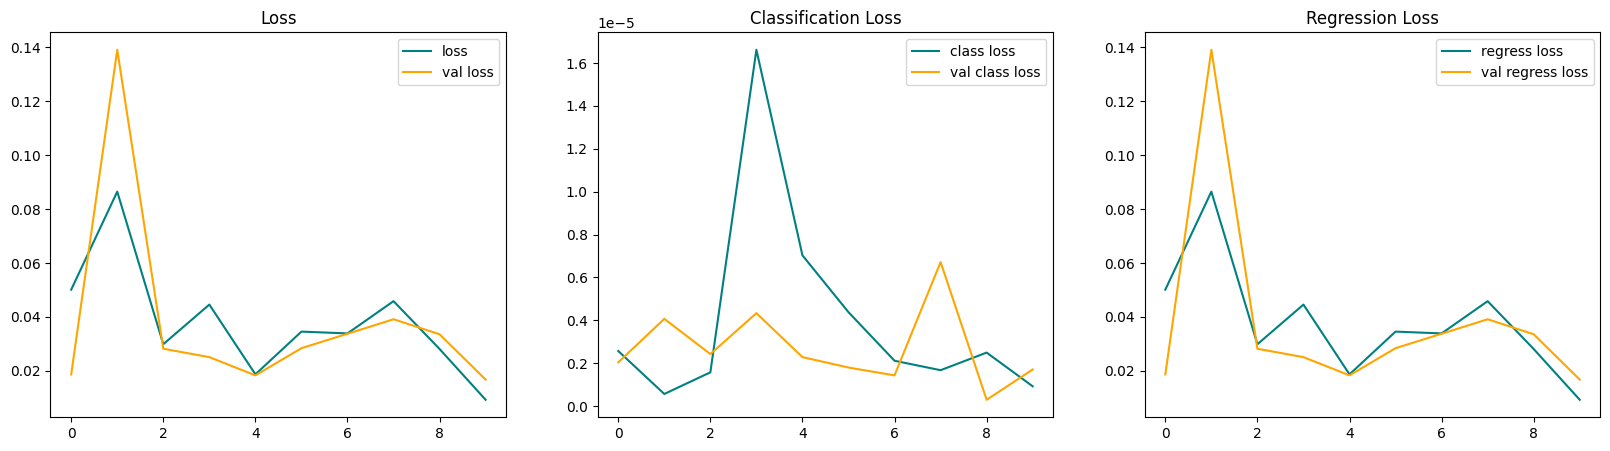

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

1/1 [==============================] - 0s 264ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


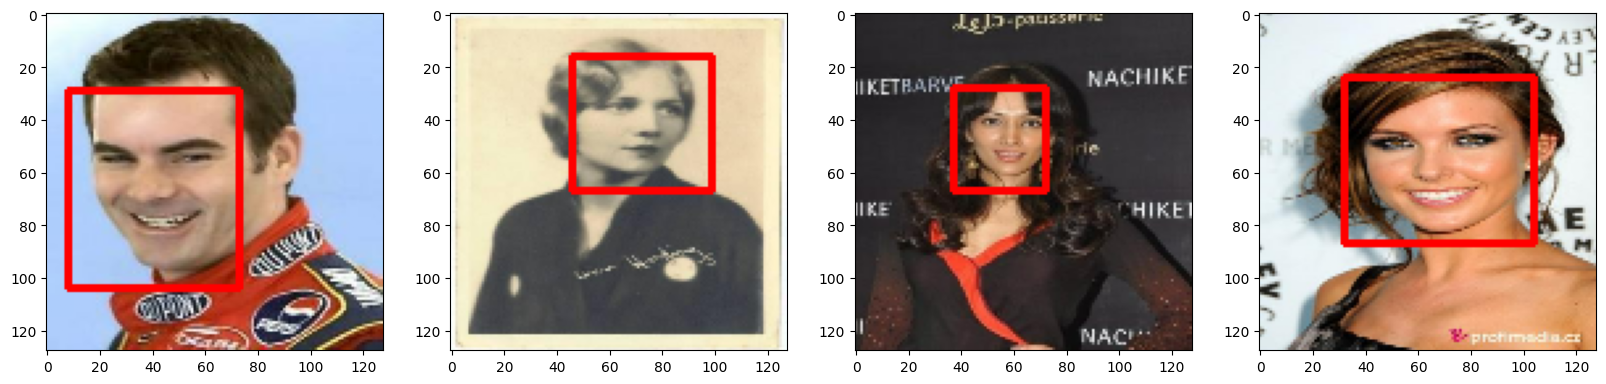

In [9]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [128,128]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [128,128]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
#facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (128,128))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
